In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

 ········


### 1- Create an SQL query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
        SELECT 	f.*, i.*, r.*
        FROM film f
        JOIN inventory i ON f.film_id = i.inventory_id
        JOIN rental r ON i.inventory_id = r.inventory_id;
        '''

### 2- Read the data into a Pandas dataframe

In [3]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,...,film_id,store_id,last_update,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,ACADEMY DINOSAUR,An Epic Drama of a Feminist And a Mad Scientis...,2006,1,None,6,0.99,86,20.99,...,1,1,2006-02-15 05:09:17,4863,2005-07-08 19:03:15,1,431,2005-07-11 21:29:15,2,2006-02-15 21:30:53
1,1,ACADEMY DINOSAUR,An Epic Drama of a Feminist And a Mad Scientis...,2006,1,None,6,0.99,86,20.99,...,1,1,2006-02-15 05:09:17,11433,2005-08-02 20:13:10,1,518,2005-08-11 21:35:10,1,2006-02-15 21:30:53
2,1,ACADEMY DINOSAUR,An Epic Drama of a Feminist And a Mad Scientis...,2006,1,None,6,0.99,86,20.99,...,1,1,2006-02-15 05:09:17,14714,2005-08-21 21:27:43,1,279,2005-08-30 22:26:43,1,2006-02-15 21:30:53
3,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,...,1,1,2006-02-15 05:09:17,972,2005-05-30 20:21:07,2,411,2005-06-06 00:36:07,1,2006-02-15 21:30:53
4,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,...,1,1,2006-02-15 05:09:17,2117,2005-06-17 20:24:00,2,170,2005-06-23 17:45:00,2,2006-02-15 21:30:53


### 3- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables

In [39]:
data.dtypes

film_id                          int64
title                           object
description                     object
release_year                     int64
language_id                      int64
original_language_id            object
rental_duration                  int64
rental_rate                    float64
length                           int64
replacement_cost               float64
rating                          object
special_features                object
last_update             datetime64[ns]
inventory_id                     int64
film_id                          int64
store_id                         int64
last_update             datetime64[ns]
rental_id                        int64
rental_date             datetime64[ns]
inventory_id                     int64
customer_id                      int64
return_date             datetime64[ns]
staff_id                         int64
last_update             datetime64[ns]
dtype: object

In [41]:
#data.isna().sum()
data = data.fillna(0)

In [31]:
#data.shape
#data.isna().sum()
#data = data[data['customer_id'].isna() == False] # dropna() is also a good option
#data
#data['customer_id'] = data['customer_id'].astype('object') # treating duration as categorical

for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

CHICAGO NORTH          5
PAYCHECK WAIT          5
OUTBREAK DIVINE        5
CELEBRITY HORN         5
CREEPERS KANE          5
                      ..
FREDDY STORM           2
LADYBUGS ARMAGEDDON    2
WIFE TURN              2
PARTY KNOCK            2
CALENDAR GUNFIGHT      2
Name: title, Length: 999, dtype: int64 

A Intrepid Yarn of a Frisbee And a Dog who must Build a Astronaut in A Baloon Factory             5
A Unbelieveable Reflection of a Explorer And a Boat who must Conquer a Woman in California        5
A Emotional Yarn of a Composer And a Man who must Escape a Butler in The Gulf of Mexico           5
A Intrepid Drama of a Astronaut And a Crocodile who must Find a Boat in Soviet Georgia            5
A Beautiful Character Study of a Sumo Wrestler And a Dentist who must Find a Dog in California    5
                                                                                                 ..
A Lacklusture Story of a Madman And a Teacher who must Kill a Frisbee in The Gulf of

In [43]:
data = data.drop(['release_year', 'language_id'], axis=1)

In [44]:
data['rental_duration'] = data['rental_duration'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')

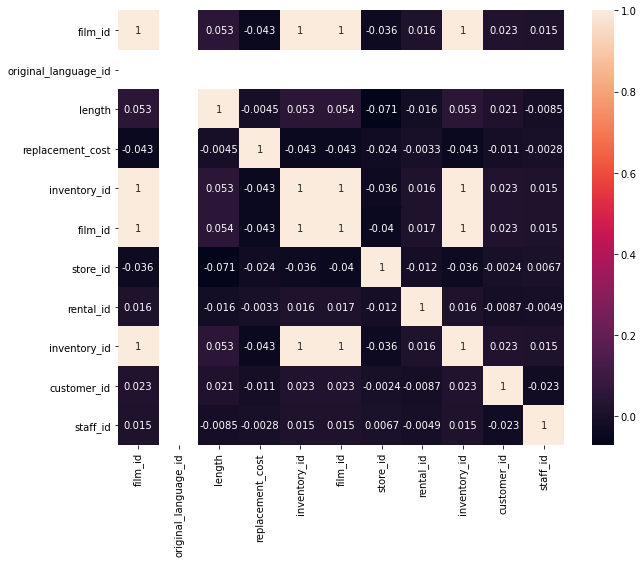

In [45]:
corr_matrix=data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

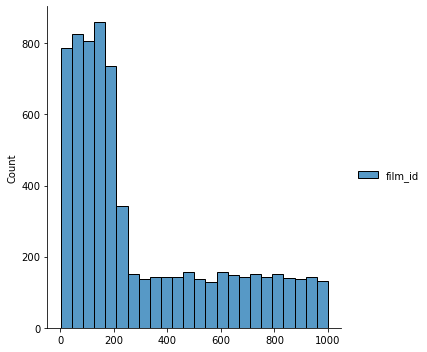

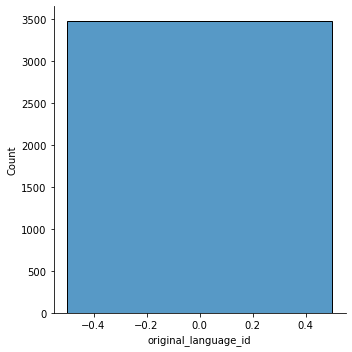

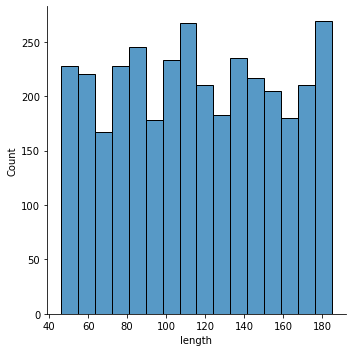

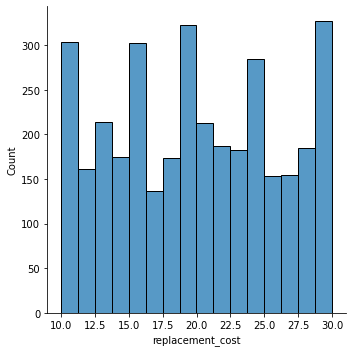

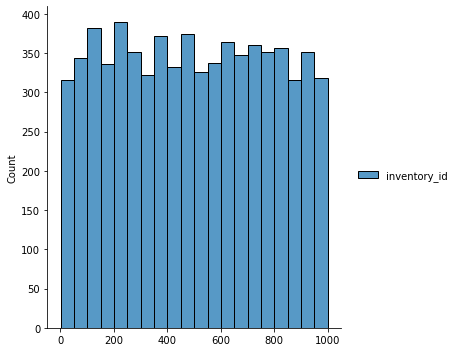

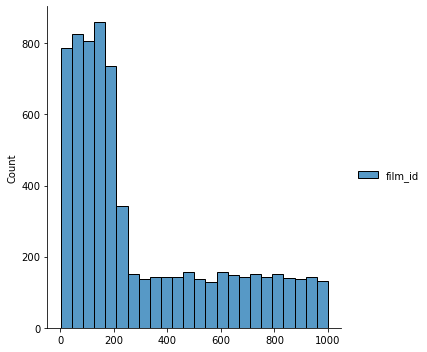

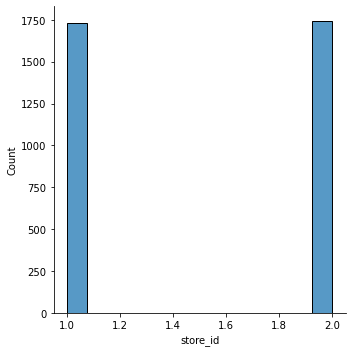

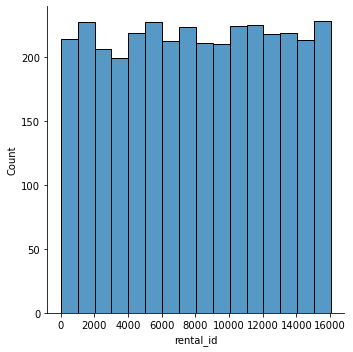

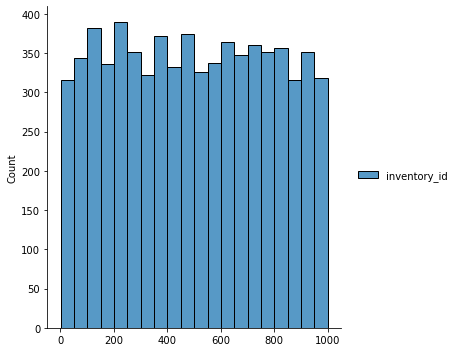

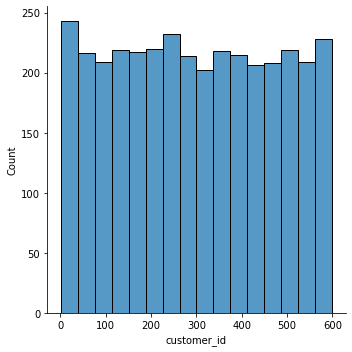

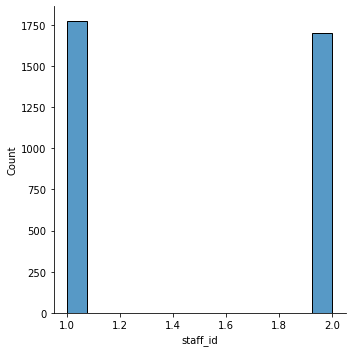

In [46]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

### 4- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable

In [57]:
query1 = '''
        with cte as
            (
            SELECT r.rental_date AS actual_rental_date
                    , f.film_id
                    , CASE WHEN LAG(r.rental_date) OVER() THEN TRUE ELSE FALSE END AS rented_previous_date
            FROM film f
            JOIN inventory i ON f.film_id = i.inventory_id
            JOIN rental r ON i.inventory_id = r.inventory_id
            ORDER BY 1
            )
        SELECT *
        FROM cte;
        '''

In [58]:
data1 = pd.read_sql_query(query1, engine)
data1.head()

,actual_rental_date,film_id,rented_previous_date
0,2005-05-24 22:53:30,367,1
1,2005-05-25 00:43:11,389,1
2,2005-05-25 01:06:36,830,1
3,2005-05-25 01:59:46,146,1
4,2005-05-25 02:19:23,727,1


In [47]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

CHICAGO NORTH          5
PAYCHECK WAIT          5
OUTBREAK DIVINE        5
CELEBRITY HORN         5
CREEPERS KANE          5
                      ..
FREDDY STORM           2
LADYBUGS ARMAGEDDON    2
WIFE TURN              2
PARTY KNOCK            2
CALENDAR GUNFIGHT      2
Name: title, Length: 999, dtype: int64 

A Intrepid Yarn of a Frisbee And a Dog who must Build a Astronaut in A Baloon Factory             5
A Unbelieveable Reflection of a Explorer And a Boat who must Conquer a Woman in California        5
A Emotional Yarn of a Composer And a Man who must Escape a Butler in The Gulf of Mexico           5
A Intrepid Drama of a Astronaut And a Crocodile who must Find a Boat in Soviet Georgia            5
A Beautiful Character Study of a Sumo Wrestler And a Dentist who must Find a Dog in California    5
                                                                                                 ..
A Lacklusture Story of a Madman And a Teacher who must Kill a Frisbee in The Gulf of

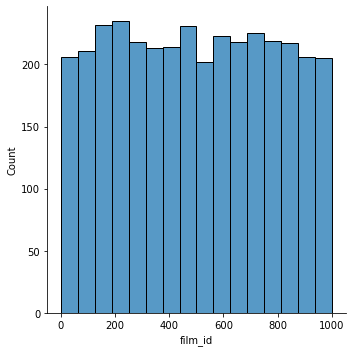

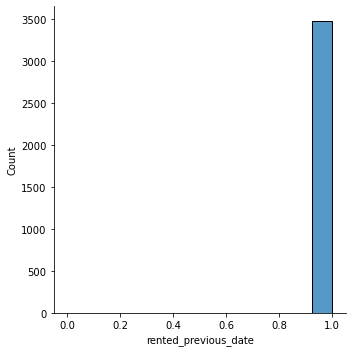

In [18]:
for col in data2.select_dtypes(np.number):
    sns.displot(data2[col])
    plt.show()

### 5- Create a logistic regression model to predict this variable from the cleaned data

In [48]:
X = data
X

,film_id,title,description,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,...,film_id,store_id,last_update,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,ACADEMY DINOSAUR,An Epic Drama of a Feminist And a Mad Scientis...,0,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",...,1,1,2006-02-15 05:09:17,4863,2005-07-08 19:03:15,1,431,2005-07-11 21:29:15,2,2006-02-15 21:30:53
1,1,ACADEMY DINOSAUR,An Epic Drama of a Feminist And a Mad Scientis...,0,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",...,1,1,2006-02-15 05:09:17,11433,2005-08-02 20:13:10,1,518,2005-08-11 21:35:10,1,2006-02-15 21:30:53
2,1,ACADEMY DINOSAUR,An Epic Drama of a Feminist And a Mad Scientis...,0,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",...,1,1,2006-02-15 05:09:17,14714,2005-08-21 21:27:43,1,279,2005-08-30 22:26:43,1,2006-02-15 21:30:53
3,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,0,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",...,1,1,2006-02-15 05:09:17,972,2005-05-30 20:21:07,2,411,2005-06-06 00:36:07,1,2006-02-15 21:30:53
4,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,0,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",...,1,1,2006-02-15 05:09:17,2117,2005-06-17 20:24:00,2,170,2005-06-23 17:45:00,2,2006-02-15 21:30:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,999,ZOOLANDER FICTION,A Fateful Reflection of a Waitress And a Boat ...,0,5,2.99,101,28.99,R,"Trailers,Deleted Scenes",...,223,2,2006-02-15 05:09:17,12319,2005-08-18 06:26:45,999,368,2005-08-23 01:35:45,1,2006-02-15 21:30:53
3471,1000,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,0,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",...,223,2,2006-02-15 05:09:17,1235,2005-06-15 04:31:28,1000,255,2005-06-22 10:08:28,1,2006-02-15 21:30:53
3472,1000,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,0,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",...,223,2,2006-02-15 05:09:17,5987,2005-07-11 00:55:31,1000,447,2005-07-16 06:28:31,2,2006-02-15 21:30:53
3473,1000,ZORRO ARK,A Intrepid Panorama of a Mad Scientist And a B...,0,3,4.99,50,18.99,NC-17,"Trailers,Commentaries,Behind the Scenes",...,223,2,2006-02-15 05:09:17,8441,2005-07-29 07:33:05,1000,526,2005-08-04 04:00:05,2,2006-02-15 21:30:53


In [49]:
X = pd.get_dummies(X)
X

,film_id,original_language_id,length,replacement_cost,last_update,inventory_id,film_id,store_id,last_update,rental_id,...,return_date_2005-08-02 12:27:38,return_date_2005-08-22 17:08:54,return_date_2005-06-29 00:35:31,return_date_2005-07-12 20:16:33,return_date_2005-08-01 11:37:13,return_date_2005-08-23 01:35:45,return_date_2005-06-22 10:08:28,return_date_2005-07-16 06:28:31,return_date_2005-08-04 04:00:05,return_date_2005-08-24 10:25:53
0,1,0,86,20.99,2006-02-15 05:03:42,1,1,1,2006-02-15 05:09:17,4863,...,0,0,0,0,0,0,0,0,0,0
1,1,0,86,20.99,2006-02-15 05:03:42,1,1,1,2006-02-15 05:09:17,11433,...,0,0,0,0,0,0,0,0,0,0
2,1,0,86,20.99,2006-02-15 05:03:42,1,1,1,2006-02-15 05:09:17,14714,...,0,0,0,0,0,0,0,0,0,0
3,2,0,48,12.99,2006-02-15 05:03:42,2,1,1,2006-02-15 05:09:17,972,...,0,0,0,0,0,0,0,0,0,0
4,2,0,48,12.99,2006-02-15 05:03:42,2,1,1,2006-02-15 05:09:17,2117,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,999,0,101,28.99,2006-02-15 05:03:42,999,223,2,2006-02-15 05:09:17,12319,...,0,0,0,0,0,1,0,0,0,0
3471,1000,0,50,18.99,2006-02-15 05:03:42,1000,223,2,2006-02-15 05:09:17,1235,...,0,0,0,0,0,0,1,0,0,0
3472,1000,0,50,18.99,2006-02-15 05:03:42,1000,223,2,2006-02-15 05:09:17,5987,...,0,0,0,0,0,0,0,1,0,0
3473,1000,0,50,18.99,2006-02-15 05:03:42,1000,223,2,2006-02-15 05:09:17,8441,...,0,0,0,0,0,0,0,0,1,0


In [59]:
y = data1
y

,actual_rental_date,film_id,rented_previous_date
0,2005-05-24 22:53:30,367,1
1,2005-05-25 00:43:11,389,1
2,2005-05-25 01:06:36,830,1
3,2005-05-25 01:59:46,146,1
4,2005-05-25 02:19:23,727,1
...,...,...,...
3470,2006-02-14 15:16:03,922,1
3471,2006-02-14 15:16:03,925,1
3472,2006-02-14 15:16:03,973,1
3473,2006-02-14 15:16:03,981,1


In [60]:
y = y.fillna(0)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### 6- Evaluate the results (calculate the score of the model)

In [ ]:
classification = LogisticRegression(random_state=42, max_iter=500) 
classification.fit(X_train, y_train)

In [ ]:
classification.score(X_test, y_test)

In [ ]:
predictions = classification.predict(X_test)
pd.Series(predictions).value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()